In [1]:
suppressPackageStartupMessages(suppressWarnings({
  library(arrow)
  library(dplyr)
  library(tidyr)
  library(ggplot2)
}))

In [2]:
tukey_results_file_path <- file.path(
    "../data/0.ground_truth/tukey_results.parquet"
)
intensity_features_file_path <- file.path(
    "../data/0.ground_truth/annexinv_intensity_features_df.parquet"
)

# Read the intensity features
intensity_features_df <- arrow::read_parquet(intensity_features_file_path)

tukey_df <- arrow::read_parquet(tukey_results_file_path)
head(tukey_df)

group1,group2,meandiff,p-adj,lower,upper,reject,feature,p-adj_bh,__index_level_0__
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<int>
0,0.61,-0.5173,0.9764,-1.9780,0.9435,FALSE,Intensity_LowerQuartileIntensity_AnnexinV,1,0
0,1.22,0.0414,1.0000,-1.4194,1.5022,FALSE,Intensity_LowerQuartileIntensity_AnnexinV,1,1
0,2.44,0.3673,0.9980,-1.0935,1.8280,FALSE,Intensity_LowerQuartileIntensity_AnnexinV,1,2
0,4.88,-0.1914,1.0000,-1.6522,1.2694,FALSE,Intensity_LowerQuartileIntensity_AnnexinV,1,3
0,9.77,0.2276,1.0000,-1.2332,1.6884,FALSE,Intensity_LowerQuartileIntensity_AnnexinV,1,4
0,19.53,-0.1448,1.0000,-1.6056,1.3160,FALSE,Intensity_LowerQuartileIntensity_AnnexinV,1,5


In [3]:
# get the intesnity feature only
tukey_df <- tukey_df %>% filter(feature == "Intensity_MedianIntensity_AnnexinV")

In [4]:
# tidy long
intensity_features_df <- intensity_features_df %>%
    pivot_longer(
        cols = colnames(intensity_features_df)[-1],
        names_to = "feature",
        values_to = "value"
    )

# select only annexin features 
intensity_features_df$channel <- gsub("Intensity_", "", intensity_features_df$feature)
intensity_features_df$channel <- sub(".*_(.*)", "\\1", intensity_features_df$feature)
intensity_features_df <- intensity_features_df %>% filter(
    channel == "AnnexinV"
)
head(intensity_features_df)

Metadata_dose,feature,value,channel
<dbl>,<chr>,<dbl>,<chr>
1.22,Intensity_LowerQuartileIntensity_AnnexinV,-0.7034650,AnnexinV
1.22,Intensity_MaxIntensity_AnnexinV,-0.7699597,AnnexinV
1.22,Intensity_MeanIntensity_AnnexinV,-0.4534940,AnnexinV
1.22,Intensity_MedianIntensity_AnnexinV,-0.1078328,AnnexinV
1.22,Intensity_LowerQuartileIntensity_AnnexinV,-0.7034650,AnnexinV
1.22,Intensity_MaxIntensity_AnnexinV,-0.8746906,AnnexinV


In [5]:
intensity_features_df$Metadata_dose <- as.character(intensity_features_df$Metadata_dose)
intensity_features_df$Metadata_dose <- factor(
    intensity_features_df$Metadata_dose,
    levels = c(
        '0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
)
    )

### Plot the intensity features for each feature and dose

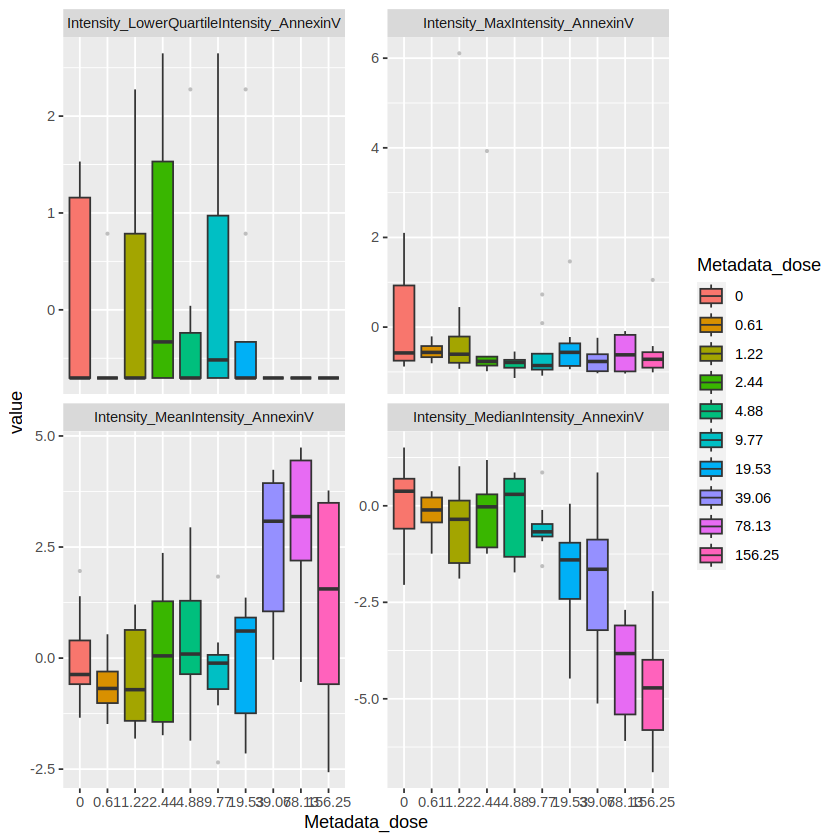

In [6]:
# plot the intensity_features_df
intensity_plot <- (
    ggplot(intensity_features_df, aes(x = Metadata_dose, y = value, fill = Metadata_dose))
    + geom_boxplot(aes(group=Metadata_dose), outlier.size = 0.5, outlier.colour = "gray")
    + facet_wrap(~ feature, scales = "free_y", ncol = 2)
)
intensity_plot

In [7]:
# sort the data by group1 and group2
tukey_df <- tukey_df %>%
    arrange(group1, group2)
# make sure the group1 and group2 are factors
tukey_df$comparison <- paste0(
  tukey_df$group1, "_", tukey_df$group2
)
tukey_df$channel <- sub(".*_(.*)", "\\1", tukey_df$feature)

### Add the tukey post hoc test plot

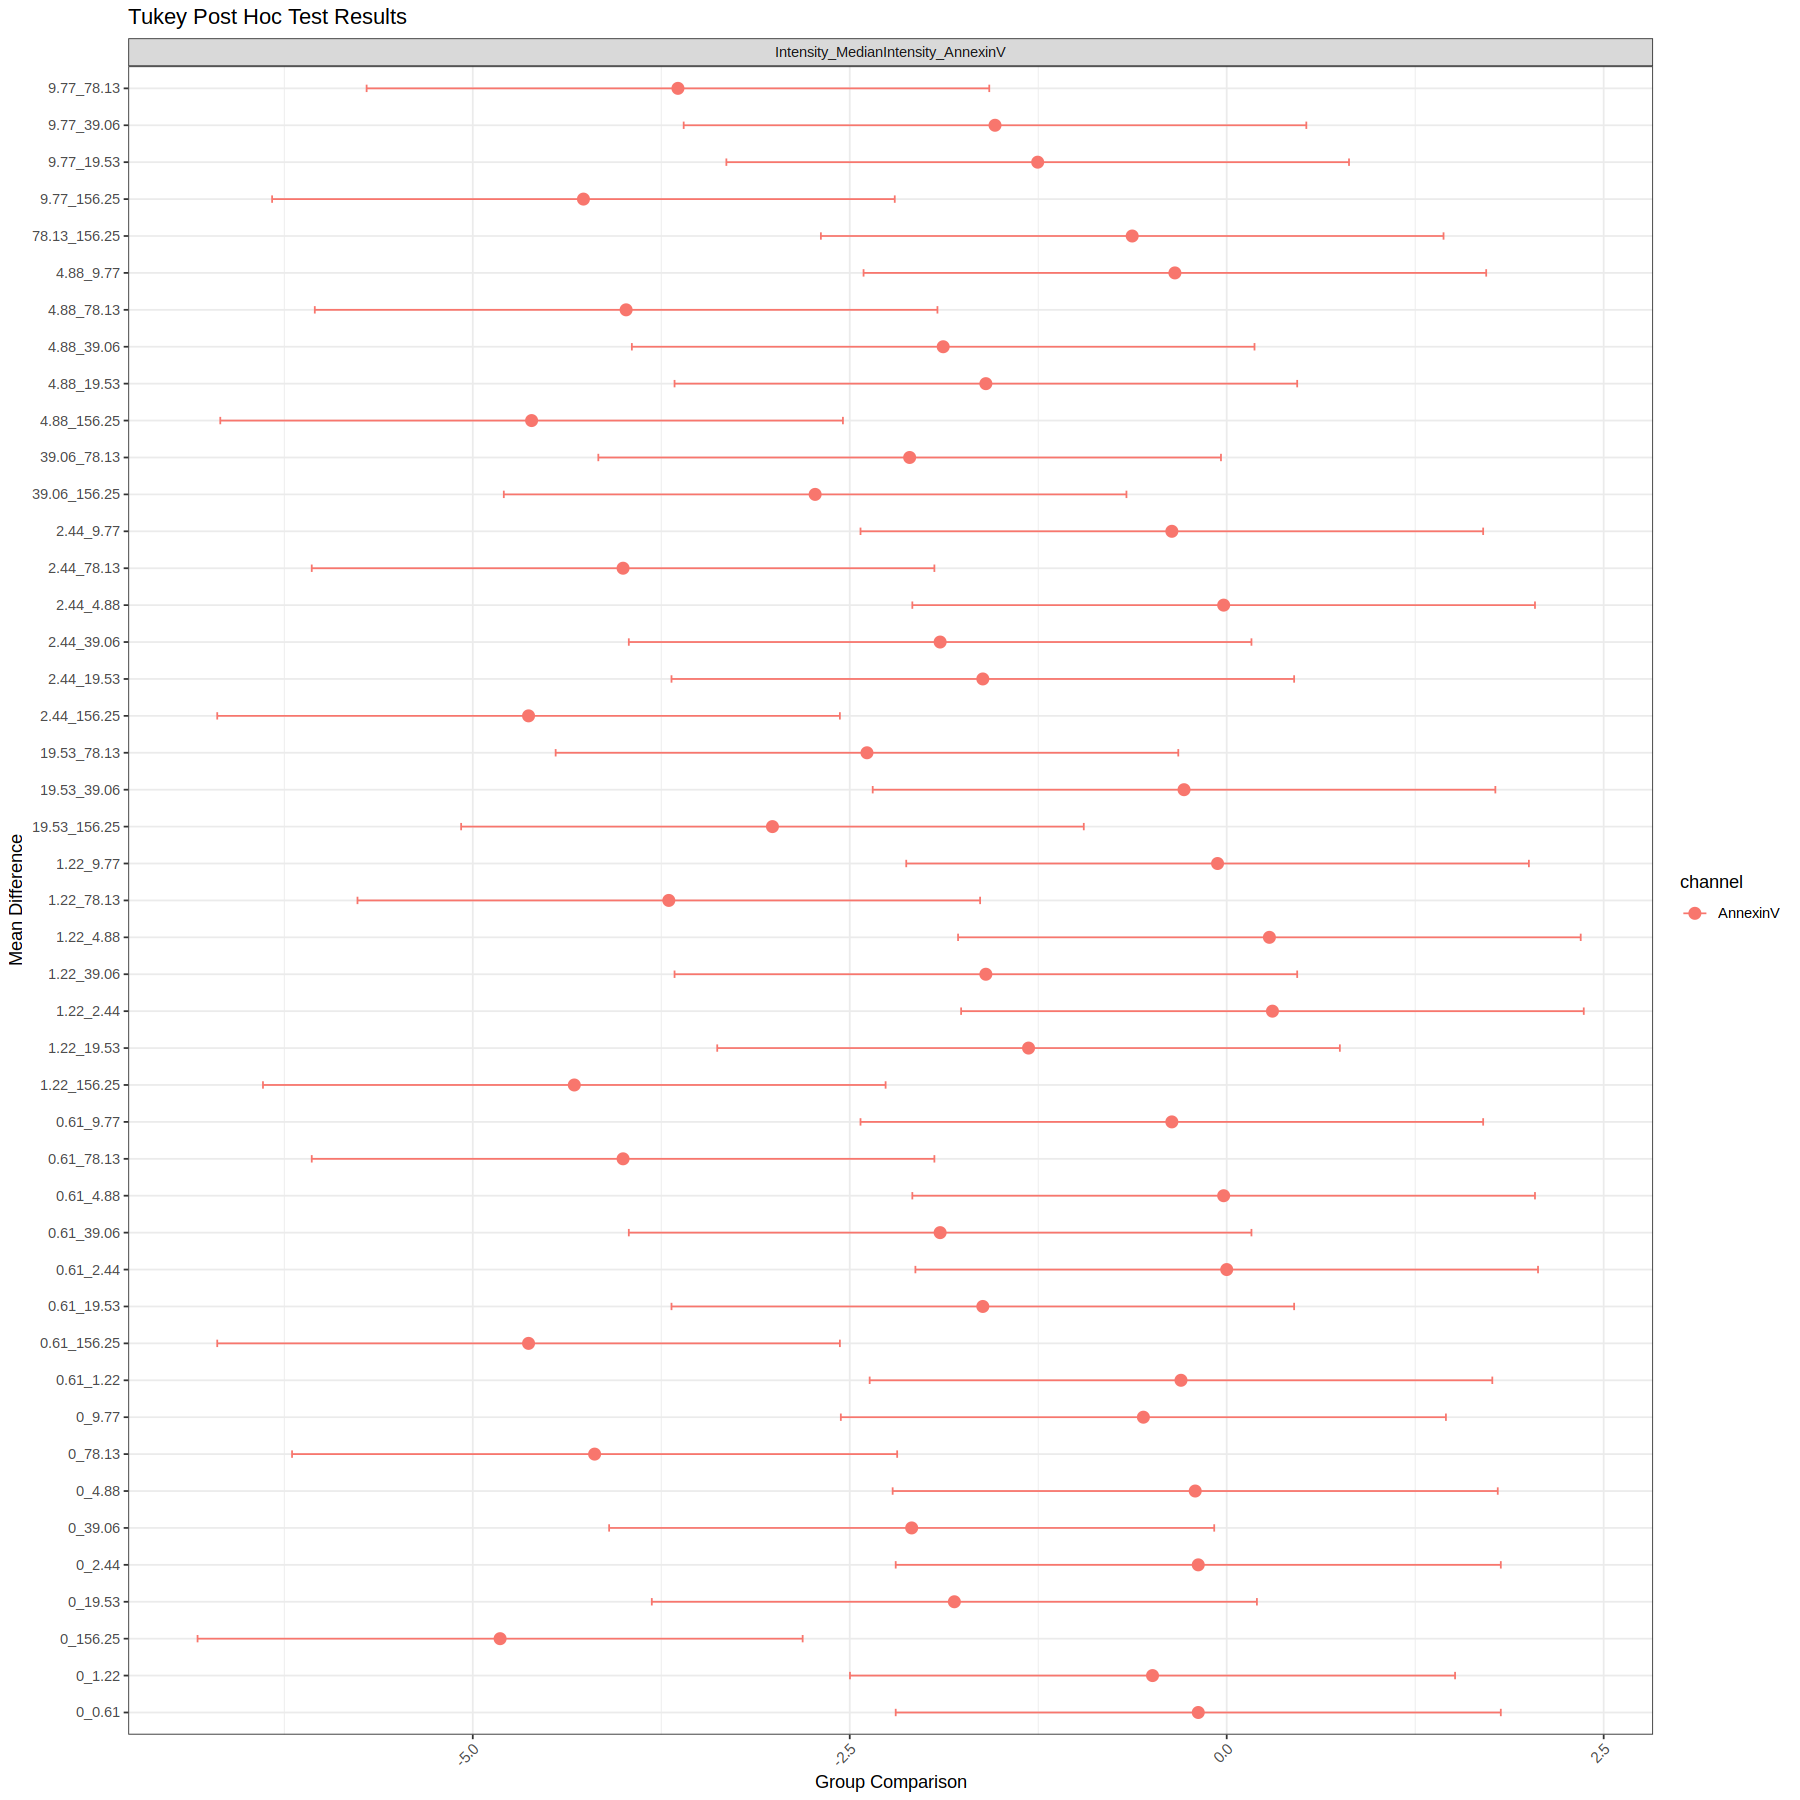

In [8]:
width <- 15
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
tukey_plot <- (
    ggplot(tukey_df, aes(x = meandiff, y = comparison, col = channel)) 
    + geom_point(size = 3) 
    + geom_errorbar(aes(xmin = lower, xmax = upper), width = 0.2) 
    + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 
    + labs(
        title = "Tukey Post Hoc Test Results",
        x = "Group Comparison",
        y = "Mean Difference"
    ) 
    + theme_bw() 
    + theme(axis.text.x = element_text(angle = 45, hjust = 1)) 
    + facet_wrap(feature ~ ., scales = "free_y") 
)
tukey_plot
